In [0]:
import numpy as np
import pandas as pd
from collections import Counter
import sqlite3
import re
from bs4 import BeautifulSoup

In [0]:
con = sqlite3.connect('gdrive/My Drive/final.sqlite')

In [0]:
df = pd.read_sql_query('SELECT * FROM Reviews WHERE Score !=3', con)

In [0]:
df.Score.replace(to_replace='positive', value=1, inplace=True)

In [0]:
df.Score.replace(to_replace='negative', value=0, inplace=True)

In [15]:
df.Score.value_counts()

1    307061
0     57110
Name: Score, dtype: int64

In [0]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
All_reviews = []
for sentence in df['Text'].values:
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    sentence = ''.join(word.lower() for word in sentence)
    All_reviews.append(sentence)

In [18]:
len(All_reviews)

364171

In [0]:
All_words = []
for sent in All_reviews:
    x = sent.split()
    for i in x:
        All_words.append(i)

In [20]:
len(All_words)

28265386

In [0]:
counts = {}
for i in All_words:
    if i in counts:
        counts[i] += 1
    else:
        counts[i] = 1

In [0]:
words = list(counts.keys())
values = list(counts.values())

In [0]:
data = {'words': words, 'frequency': values}

In [0]:
df = pd.DataFrame.from_dict(data=data)

In [0]:
new_df = df.sort_values(by='frequency', ascending=False)

In [26]:
new_df

,frequency,words
14,1148401,the
10,1050100,i
21,810985,and
41,747003,a
12,683406,it
27,650646,is
45,631074,to
40,486339,of
0,432340,this
147,377639,not


In [0]:
indices = list(new_df.index)
words = list(new_df.words)

In [0]:
index_series = pd.Series(data=indices, name='indices')

In [0]:
words_series = pd.Series(data=words, name='words')

In [0]:
words = list(words_series)

In [0]:
df = pd.concat([index_series, words_series], axis=1)

In [0]:
df.reset_index(inplace=True)

In [33]:
All_reviews[0]

'this witty little book makes my son laugh at loud i recite it in the car as we are driving along and he always can sing the refrain he is learned about whales india drooping roses i love all the new words this book introduces and the silliness of it all this is a classic book i am willing to bet my son will still be able to recite from memory when he is in college'

In [0]:
from tqdm import tqdm

In [0]:
words = df['words']
indices = df['index']

In [0]:
from itertools import zip_longest

In [0]:
rank_dict={}
for i,j in zip_longest(words, indices):
    rank_dict[i] = j

In [38]:
rank_dict.get('the')

0

In [39]:
converted_reviews = []
count = 0
for review in tqdm(All_reviews):
    index=[]
    count += 1
    words = review.split()
    for word in words:
      if word in rank_dict:
        index.append(rank_dict.get(word))
      else:
        continue
    converted_reviews.insert(count, (index))

100%|██████████| 364171/364171 [00:17<00:00, 21002.77it/s]


In [40]:
len(converted_reviews)

364171

In [0]:
df = pd.read_sql_query('SELECT * FROM Reviews WHERE Score !=3', con)

In [0]:
df.Score.replace(to_replace='positive', value=1, inplace=True)

In [0]:
df.Score.replace(to_replace='negative', value=0, inplace=True)

In [0]:
X = converted_reviews
y = df['Score'].values

### LSTM

In [45]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
x_train, x_test, y_train , y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [0]:
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

In [48]:
len(x_train)

178443

In [49]:
len(y_train)

178443

In [0]:
X_train = np.asarray(x_train)
X_test = np.asarray(x_test)
X_cv = np.asarray(x_cv)

In [51]:
X_train.shape

(178443,)

In [52]:
X_test.shape

(109252,)

In [0]:
max_review_length = 600
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)
X_cv = sequence.pad_sequences(X_cv, maxlen = max_review_length)

In [55]:
X_train.shape

(178443, 600)

In [56]:
X_test.shape

(109252, 600)

In [63]:
X_cv.shape

(76476, 600)

### Model

In [0]:
top_words = 5000

In [58]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [59]:
'positive' in y_train

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """Entry point for launching an IPython kernel.


False

In [64]:
model.fit(X_train[:80000], y_train[:80000], epochs=5, batch_size=80, validation_data=(X_cv, y_cv))

# Final evaluation of the model
scores = model.evaluate(X_cv, y_cv, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 80000 samples, validate on 76476 samples
Epoch 1/5
80000/80000 [==============================] - 1515s 19ms/step - loss: 2.5206 - acc: 0.8416 - val_loss: 2.4853 - val_acc: 0.8441
Epoch 2/5
80000/80000 [==============================] - 1518s 19ms/step - loss: 2.5245 - acc: 0.8416 - val_loss: 2.4853 - val_acc: 0.8441
Epoch 3/5
80000/80000 [==============================] - 1541s 19ms/step - loss: 2.5245 - acc: 0.8416 - val_loss: 2.4853 - val_acc: 0.8441
Epoch 4/5
80000/80000 [==============================] - 1517s 19ms/step - loss: 2.5245 - acc: 0.8416 - val_loss: 2.4853 - val_acc: 0.8441
Epoch 5/5
80000/80000 [==============================] - 1528s 19ms/step - loss: 2.5245 - acc: 0.8416 - val_loss: 2.4853 - val_acc: 0.8441
Accuracy: 84.41%


In [0]:
import matplotlib.pyplot as plt

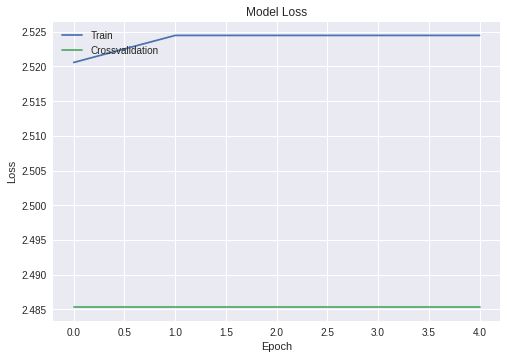

In [67]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Crossvalidation'], loc='upper left')
plt.show()

# MODEL 2

In [0]:
top_words = 5000

In [69]:
# create the model
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(2, return_sequences=True))
model.add(LSTM(2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 2)            280       
_________________________________________________________________
lstm_3 (LSTM)                (None, 2)                 40        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 160,323
Trainable params: 160,323
Non-trainable params: 0
_________________________________________________________________
None


In [71]:
model.fit(X_train[:80000], y_train[:80000], epochs=5, batch_size=80, validation_data=(X_cv, y_cv))

# Final evaluation of the model

scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 80000 samples, validate on 76476 samples
Epoch 1/5
80000/80000 [==============================] - 3015s 38ms/step - loss: 0.9576 - acc: 0.8462 - val_loss: 2.4853 - val_acc: 0.8441
Epoch 2/5
80000/80000 [==============================] - 3024s 38ms/step - loss: 2.5245 - acc: 0.8416 - val_loss: 2.4853 - val_acc: 0.8441
Epoch 3/5
80000/80000 [==============================] - 3000s 38ms/step - loss: 2.5245 - acc: 0.8417 - val_loss: 2.4853 - val_acc: 0.8441
Epoch 4/5
80000/80000 [==============================] - 2955s 37ms/step - loss: 2.5245 - acc: 0.8416 - val_loss: 2.4853 - val_acc: 0.8441
Epoch 5/5
80000/80000 [==============================] - 3026s 38ms/step - loss: 2.5245 - acc: 0.8417 - val_loss: 2.4853 - val_acc: 0.8441
Accuracy: 84.34%


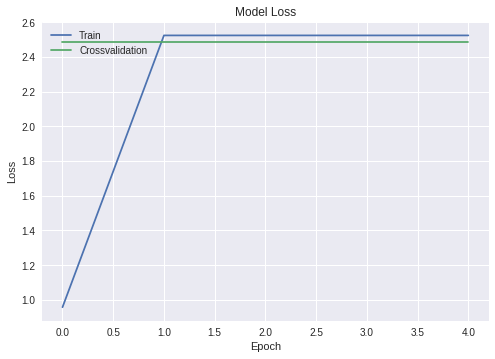

In [72]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Crossvalidation'], loc='upper left')
plt.show()

In [73]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 600, 2)            280       
_________________________________________________________________
lstm_3 (LSTM)                (None, 2)                 40        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 160,323
Trainable params: 160,323
Non-trainable params: 0
_________________________________________________________________


In [0]:
from prettytable import PrettyTable

In [0]:
x = PrettyTable()
x.field_names = (['architecture','train accuracy', 'validation accuracy'])

In [0]:
x.add_row(['LSTM(100)',84.16, 84.42])

In [0]:
x.add_row(['LSTM(2) - LSTM(2)', 84.17, 84.34])

In [91]:
print(x)

+-------------------+----------------+---------------------+
|    architecture   | train accuracy | validation accuracy |
+-------------------+----------------+---------------------+
|     LSTM(100)     |     84.16      |        84.42        |
| LSTM(2) - LSTM(2) |     84.17      |        84.34        |
+-------------------+----------------+---------------------+
